In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import tensorflow as tf

/Users/ghbhgtgh/opt/anaconda3/envs/slp/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-10-30 20:12:36.350133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train Models

## Load Data

In [2]:
# load combined dataset features
train_df = pd.read_csv("combined_processed_train_filtered.csv", index_col='Unnamed: 0')
test_df = pd.read_csv("combined_processed_test_filtered.csv", index_col='Unnamed: 0')
train_df.head(2)

,dialog_id,speaker,da_tag,function,pronoun,ppron,i,we,you,shehe,...,Max Pitch,Mean Pitch,Sd Pitch,Max Intensity,Mean Intensity,Sd Intensity,Speaking Rate,Jitter,Shimmer,HNR
1,sw2005,A,sd,0.65,0.200000,0.150000,0.1,0.0,0.0,0.050000,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45
2,sw2005,A,sd,0.50,0.055556,0.055556,0.0,0.0,0.0,0.055556,...,561.691,23.98,50.946,81.406,39.0,23.787,10.196142,0.016,0.087,13.45


## Train Model

### Speech Features Only

#### Build Pipleline

In [3]:
speech_features = ['Max Pitch','Mean Pitch','Sd Pitch','Max Intensity','Mean Intensity','Sd Intensity',\
                   'Speaking Rate','Jitter','Shimmer','HNR']

In [4]:
# drop identifier features from dataframe
features_to_discard = ['dialog_id', 'speaker', 'da_tag']  # training features
target_features = ['da_tag']

# normalize each numerical features and one hot encode target
# pipeline both operations

all_features = speech_features

X_train, y_train = train_df.drop(features_to_discard, axis=1), train_df['da_tag']
X_test, y_test = test_df.drop(features_to_discard, axis=1), test_df['da_tag']

In [5]:
# perform scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1 hot encode target variables
y_train_dict = dict(list(zip(list(np.unique(y_train)), np.eye(10))))
y_train_cateogical = np.array(list(map(lambda x: y_train_dict[x], y_train)))
y_test_cateogical = np.array(list(map(lambda x: y_train_dict[x], y_test)))
print(y_train_dict)

{'%': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '+': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'aa': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'b': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'ba': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'qw': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'qy': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'sd': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'sd^e': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'sv': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


#### Train

In [6]:
model_s = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_s.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

2022-10-30 20:12:41.239664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
history_s = model_s.fit(X_train, y_train_cateogical, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
966/966 [==============================] - 2s 2ms/step - loss: 1.6653 - accuracy: 0.4840 - val_loss: 1.3478 - val_accuracy: 0.4849
Epoch 2/50
966/966 [==============================] - 1s 2ms/step - loss: 1.3984 - accuracy: 0.5269 - val_loss: 1.2318 - val_accuracy: 0.5096
Epoch 3/50
966/966 [==============================] - 2s 2ms/step - loss: 1.3046 - accuracy: 0.5420 - val_loss: 1.1804 - val_accuracy: 0.5195
Epoch 4/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2635 - accuracy: 0.5501 - val_loss: 1.1610 - val_accuracy: 0.5250
Epoch 5/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2311 - accuracy: 0.5557 - val_loss: 1.1355 - val_accuracy: 0.5428
Epoch 6/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2068 - accuracy: 0.5640 - val_loss: 1.1225 - val_accuracy: 0.5417
Epoch 7/50
966/966 [==============================] - 2s 2ms/step - loss: 1.1875 - accuracy: 0.5695 - val_loss: 1.1216 - val_accuracy: 0.5400
Epoch 

### Text Features Only

#### Build Pipleline

In [8]:
text_features = ['function','pronoun','ppron','i','we','you','shehe','they','ipron','article','prep','auxverb',\
                 'adverb','conj','negate','verb','adj','compare','interrog','number','quant','affect','posemo',\
                 'negemo','anx','anger','sad','social','family','friend','female','male','cogproc','insight',\
                 'cause','discrep','tentat','certain','differ','percept','see','hear','feel','bio','body',\
                 'health','sexual','ingest','drives','affiliation','achieve','power','reward','risk','focuspast',\
                 'focuspresent','focusfuture','relativ','motion','space','time','work','leisure','home','money',\
                 'relig','death','informal','swear','netspeak','assent','nonflu','filler']

In [9]:
# drop identifier features from dataframe
features_to_discard = ['dialog_id', 'speaker', 'da_tag']  # training features
target_features = ['da_tag']

# normalize each numerical features and one hot encode target
# pipeline both operations

all_features = speech_features

X_train = train_df.drop(features_to_discard, axis=1)
X_test = test_df.drop(features_to_discard, axis=1)

In [10]:
# perform scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1 hot encode target variables
y_train_cateogical = np.array(list(map(lambda x: y_train_dict[x], y_train)))
print(y_train_dict)

{'%': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '+': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'aa': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'b': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'ba': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'qw': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'qy': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'sd': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'sd^e': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'sv': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


#### Train

In [11]:
model_t = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_t.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [12]:
history_t = model_t.fit(X_train, y_train_cateogical, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
966/966 [==============================] - 2s 2ms/step - loss: 1.6552 - accuracy: 0.4847 - val_loss: 1.3348 - val_accuracy: 0.4959
Epoch 2/50
966/966 [==============================] - 2s 2ms/step - loss: 1.3853 - accuracy: 0.5357 - val_loss: 1.2470 - val_accuracy: 0.5097
Epoch 3/50
966/966 [==============================] - 2s 2ms/step - loss: 1.3062 - accuracy: 0.5481 - val_loss: 1.1945 - val_accuracy: 0.5216
Epoch 4/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2620 - accuracy: 0.5573 - val_loss: 1.1756 - val_accuracy: 0.5281
Epoch 5/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2336 - accuracy: 0.5600 - val_loss: 1.1537 - val_accuracy: 0.5313
Epoch 6/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2151 - accuracy: 0.5661 - val_loss: 1.1430 - val_accuracy: 0.5316
Epoch 7/50
966/966 [==============================] - 2s 2ms/step - loss: 1.1954 - accuracy: 0.5729 - val_loss: 1.1138 - val_accuracy: 0.5459
Epoch 

### Speech + Text Features

#### Build Pipleline

In [13]:
# drop identifier features from dataframe
features_to_discard = ['dialog_id', 'speaker', 'da_tag']  # training features
target_features = ['da_tag']

# normalize each numerical features and one hot encode target
# pipeline both operations

all_features = list(train_df.columns)

X_train = train_df.drop(features_to_discard, axis=1)
X_test = test_df.drop(features_to_discard, axis=1)

Scale the features and one hot encode target:

In [14]:
# perform scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1 hot encode target variables
y_train_cateogical = np.array(list(map(lambda x: y_train_dict[x], y_train)))
print(y_train_dict)

{'%': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '+': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'aa': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'b': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'ba': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'qw': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'qy': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'sd': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'sd^e': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'sv': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


#### Train

In [15]:
model_ts = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_ts.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [16]:
history_ts = model_ts.fit(X_train, y_train_cateogical, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
966/966 [==============================] - 3s 2ms/step - loss: 1.6359 - accuracy: 0.4839 - val_loss: 1.3197 - val_accuracy: 0.4991
Epoch 2/50
966/966 [==============================] - 2s 2ms/step - loss: 1.3634 - accuracy: 0.5397 - val_loss: 1.2320 - val_accuracy: 0.5075
Epoch 3/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2868 - accuracy: 0.5501 - val_loss: 1.1834 - val_accuracy: 0.5198
Epoch 4/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2584 - accuracy: 0.5536 - val_loss: 1.1558 - val_accuracy: 0.5242
Epoch 5/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2237 - accuracy: 0.5626 - val_loss: 1.1464 - val_accuracy: 0.5227
Epoch 6/50
966/966 [==============================] - 2s 2ms/step - loss: 1.2028 - accuracy: 0.5703 - val_loss: 1.1186 - val_accuracy: 0.5444
Epoch 7/50
966/966 [==============================] - 2s 2ms/step - loss: 1.1851 - accuracy: 0.5743 - val_loss: 1.1165 - val_accuracy: 0.5381
Epoch 

# Model Tests

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Accuracy & F1

In [45]:
# compute acc and f1
y_preds, acc, f1 = [], [], []
all_models = [model_s, model_t, model_ts]
for model in all_models:
    y_pred = model.predict(X_test)
    y_preds.append(np.argmax(y_pred, axis=1))
    acc.append(accuracy_score(np.argmax(y_test_cateogical, axis=1), np.argmax(y_pred, axis=1)))
    f1.append(f1_score(np.argmax(y_test_cateogical, axis=1), np.argmax(y_pred, axis=1), average='macro'))
    
print(list(map(lambda x: round(x,3), acc)), list(map(lambda x: round(x,3), f1)))

298/298 [==============================] - 0s 1ms/step
[0.64, 0.635, 0.644] [0.477, 0.471, 0.488]


<b>Result:</b>

| Model | Accuracy | F1 |
| :- | -: | :-: |
| Speech | 0.64 | 0.477
| Text | 0.635 | 0.471
| Speech+Text | 0.644 | 0.488

## Model Analysis

### a) Which feature set performed the best?

Speech+Text combined performs the best, but speech performs slightly better than text.

### b) Show the confusion matrix.

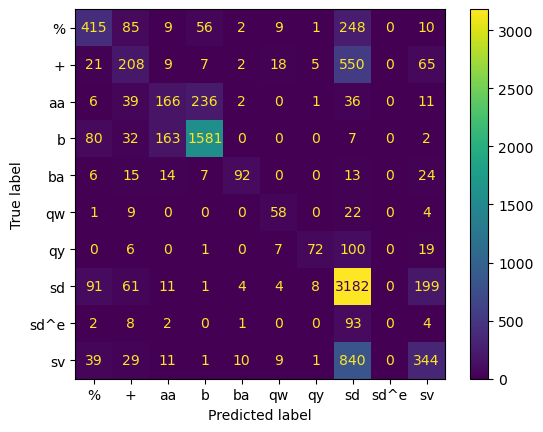

In [60]:
cm = confusion_matrix(np.argmax(y_test_cateogical, axis=1), y_preds[2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train_dict)
disp.plot()
plt.show()

### c) Which class(es) were easiest to predict? Why do you think they were easy?

According to the diagram below, we can see tag b has the highest precision, recall, and f1 (tag b is Acknowledge). Classes such as sd also has a high f1 score. These classes are easier to predict than other classes might be because they have much more audio clues and text clues. For example, acknowledgement might have a significantly high intensity than other tags.

In [62]:
# report for each class
print(classification_report(np.argmax(y_test_cateogical, axis=1), y_preds[2], target_names=y_train_dict))

              precision    recall  f1-score   support

           %       0.63      0.50      0.55       835
           +       0.42      0.24      0.30       885
          aa       0.43      0.33      0.38       497
           b       0.84      0.85      0.84      1865
          ba       0.81      0.54      0.65       171
          qw       0.55      0.62      0.58        94
          qy       0.82      0.35      0.49       205
          sd       0.63      0.89      0.74      3561
        sd^e       0.00      0.00      0.00       110
          sv       0.50      0.27      0.35      1284

    accuracy                           0.64      9507
   macro avg       0.56      0.46      0.49      9507
weighted avg       0.62      0.64      0.61      9507



/Users/ghbhgtgh/opt/anaconda3/envs/slp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghbhgtgh/opt/anaconda3/envs/slp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghbhgtgh/opt/anaconda3/envs/slp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### d) Which were the most difficult? Why do you think they were difficult?

From above classification report and confusion matrix, the model performed worst on sd^e (Statement expanding y/n answer) because it was confused with sd, and all of the sd^e had been classified as sd (statement non opinion). This might be due to model find these two tags really similar, thus cannot tell them apart since both of them are statements. One possible fix might be the feature sets should also include tag of previous sentences, so the model can distinguist whether current sentence is an answer to a question or a statement. 

### e) What were some common errors (e.g. confused classes)? Why do you think your classifier made these errors?

One of the errors are mentioned in part d. The other common errors are lots of sd (Statement-non-opinion) are classified as % (Abandoned or Turn-Exit) and + (continuation). This might be because the sentence was suitable of multiple labels, but transcript only has 1 label. 

### f) Based on this analysis, what ideas do you have to further improve your classifier/model?

Firstly, I would combine sd with sd^e to become 1 label and combine other tags with extension. Secondly, I would add another feature: previous dialogue tag of current segment. Thirdly, I would clean up the data by concatnating some of the sentences together or remove some of the duplicate sentences.